# Import Libraries

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import statsmodels.api as sm

from sklearn import preprocessing
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, Dropout, Flatten, TimeDistributed
from keras.layers import ConvLSTM2D

from pylab import rcParams
rcParams['figure.figsize'] = 12,8

warnings.filterwarnings('ignore')

# Import Data

In [58]:
data = pd.read_csv("airline_traffic.csv")
data.columns = ["Date","Passengers"]
print(data.shape)

(144, 2)


In [59]:
data.loc[:,'Date']= pd.to_datetime(data['Date'])
data = data.set_index(['Date'])

In [252]:
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [60]:
data.head(5)

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Plot Time Series Data

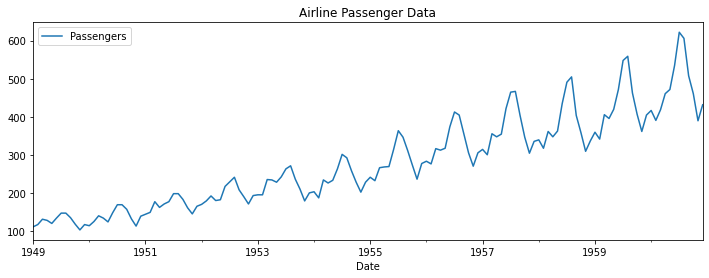

In [61]:
data.plot(figsize=(12,4))
plt.title('Airline Passenger Data')
plt.legend(loc='best')
plt.show(block=False)

# Outlier Detection

## Box Plot | Interquartile Range | Histogram

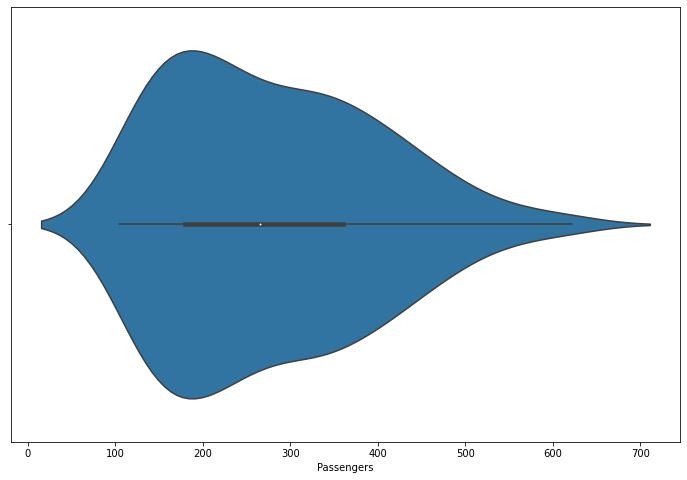

In [63]:
sns.violinplot(x= data['Passengers'],whis=1.5);

## Decomposition

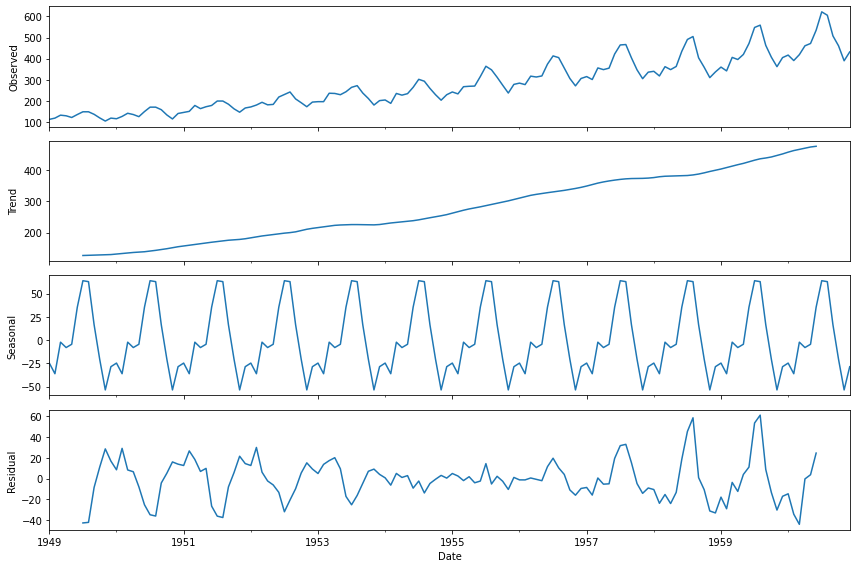

In [64]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive')
decomposition.plot();

In [265]:
import plotly.tools as tls
import plotly.graph_objects as go
from plotly import subplots

fig = subplots.make_subplots(rows=4, cols=1, subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"], shared_xaxes=True)

fig.add_trace(
    go.Scatter(x=decomposition.seasonal.index, y=decomposition.observed, mode='lines', legendgroup="observed", name="observed"),
        row=1, col=1,
    )

fig.add_trace(
    go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', legendgroup="trend", name="trend"),
        row=2, col=1,
    )

fig.add_trace(
    go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', legendgroup="seasonality", name="seasonality"),
        row=3, col=1,
    )

fig.add_trace(
    go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='markers', legendgroup = "residuals", name="residuals"),
        row=4, col=1,
    )

# Model Training and Evaluation

## Splitting Time Series into Training and Test Sets

In [70]:
split_ratio = 0.80
split_idx = int(data.shape[0]*0.80)
train=data[:split_idx]
test=data[split_idx:]

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (115, 1)
Test shape:  (29, 1)


## Modeling Approaches

The Autocorrelation plot for the data is:


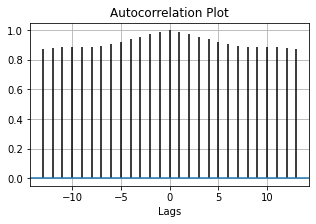

In [83]:
plt.figure(figsize=(5,3))
plt.title("Autocorrelation Plot")
plt.xlabel("Lags")

# Plotting the Autocorrelation plot.
plt.acorr(data["Passengers"].astype(float), maxlags = 13)

# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)

plt.show()

### Simple Moving Average Method

In [87]:
y_hat_sma = data.copy()
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(6).mean()
y_hat_sma['sma_forecast'][split_idx:] = y_hat_sma['sma_forecast'][split_idx-1]

**Plot Train, Test and Forecast**

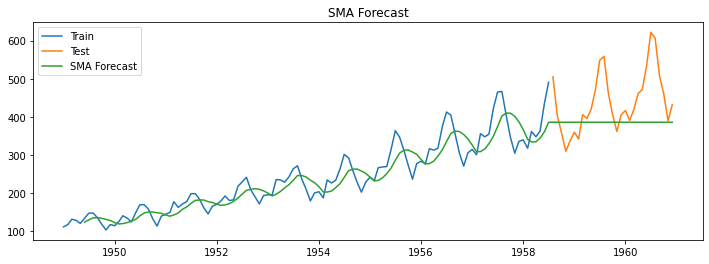

In [88]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='SMA Forecast')
plt.legend(loc='best')
plt.title('SMA Forecast')
plt.show()

**Evaluation**

In [89]:
def evalutate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred)).round(2)
    mape= np.round(np.mean(np.abs(y_true- y_pred)/y_true)*100,2)

    results = pd.DataFrame({'MAPE':[mape],'RMSE':[rmse]})
    return results

In [91]:
evalutate_predictions(test['Passengers'],y_hat_sma['sma_forecast'][split_idx:])

,MAPE,RMSE
0,14.71,95.06


### Deep Learning - LSTM

In [94]:
mm_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
mm_scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [220]:
def prepare_data_for_lstm(data):
    scaled_data = mm_scaler.transform(data)
    def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    n_steps = 4
    X, y = split_sequence(scaled_data, n_steps)
    n_features = 1
    n_seq = 2
    n_steps = 2
    X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
    return X, y

In [218]:
def build_model(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [234]:
X_train, y_train = prepare_data_for_lstm(train)
X_test, y_test = prepare_data_for_lstm(test)

print("Train",X_train.shape,y_train.shape)
print("Test",X_test.shape,y_test.shape)

Train (111, 2, 1, 2, 1) (111, 1)
Test (25, 2, 1, 2, 1) (25, 1)


In [235]:
model = build_model((2, 1, 2, 1))
es = EarlyStopping(monitor='val_loss', patience=7)

H = model.fit(X_train, y_train, epochs = 500, batch_size = 32, callbacks = [es], validation_data=(X_test, y_test))

Epoch 1/500
4/4 [==============================] - 3s 96ms/step - loss: 0.1773 - val_loss: 0.7622
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1619 - val_loss: 0.7084
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1477 - val_loss: 0.6551
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 0.1340 - val_loss: 0.6030
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 0.1204 - val_loss: 0.5525
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1074 - val_loss: 0.5015
Epoch 7/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0946 - val_loss: 0.4470
Epoch 8/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0812 - val_loss: 0.3903
Epoch 9/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0680 - val_loss: 0.3329
Epoch 10/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0561 - val_loss: 0.2759
Epoch 11/500
4/4 [=

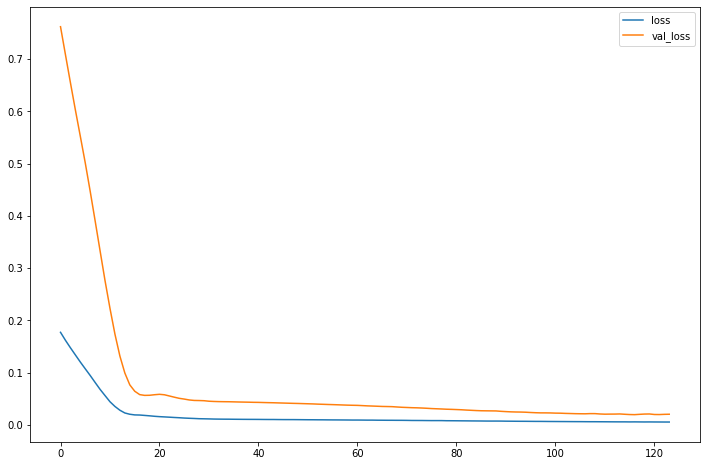

In [236]:
pd.DataFrame(H.history).plot();

**Predictions on Test data**

In [237]:
y_hat = model.predict(X_test).flatten()
assert y_test.shape[0] == y_hat.shape[0]

array([[0.60206718, 0.66149871, 0.61498708, 0.78036176, 0.75452196,
        0.81653747, 0.95090439, 1.14728682, 1.17571059, 0.92764858,
        0.78294574, 0.66666667, 0.77777778, 0.80878553, 0.74160207,
        0.81395349, 0.92248062, 0.95090439, 1.11369509, 1.33850129,
        1.29715762, 1.04392765, 0.92248062, 0.73901809, 0.84754522]])

In [240]:
y_test = sc.inverse_transform(y_test.reshape(1,-1))[0]
y_hat = sc.inverse_transform([y_hat])[0]

In [241]:
y_test.shape

(25,)

In [242]:
y_hat.shape

(25,)

In [243]:
evalutate_predictions(y_test,y_hat)

,MAPE,RMSE
0,10.11,57.39


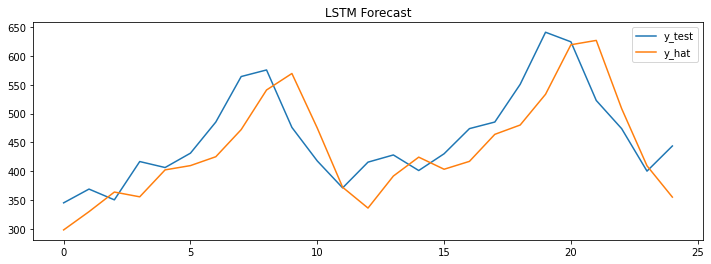

In [244]:
plt.figure(figsize=(12,4))
plt.plot(y_test,label='y_test')
plt.plot(y_hat,label='y_hat')
plt.legend(loc='best')
plt.title('LSTM Forecast')
plt.show()

In [250]:
y_hat_series = pd.Series(y_hat, index=test.index[4:]).astype(int)

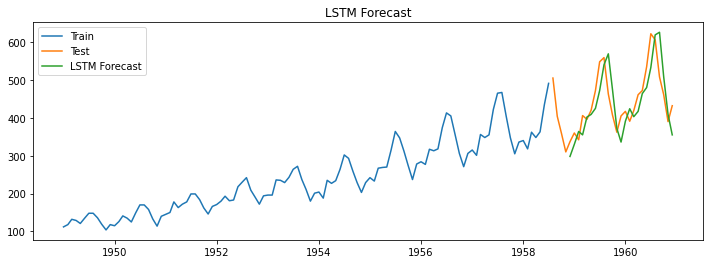

In [251]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_series, label='LSTM Forecast')
plt.legend(loc='best')
plt.title('LSTM Forecast')
plt.show()